In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix


In [2]:
def classification_evaluation(y_test, y_pred, avg="weighted"):

    precision = precision_score(y_test, y_pred, average=avg, zero_division=0)
    recall = recall_score(y_test, y_pred, average=avg, zero_division=0)
    F1_score = f1_score(y_test, y_pred, average=avg, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f'Accuracy: {round(accuracy,3)}')
    print(f'Precision: {round(precision,3)}')
    print(f'Recall: {round(recall,3)}')
    print(f'f1-score: {round(F1_score,3)}')
    print(f'Confusion matrix: \n {confusion_matrix(y_test, y_pred)}')

In [3]:
# df_summaries = pd.read_csv("data/articles_summary_cleaned.csv", parse_dates=["date"])
# df_summaries

In [4]:
# df_articles = pd.read_csv("data/all_africa_southsudan.csv")
# df_articles

In [5]:
# print(df_articles.date.unique().shape)

In [6]:
df_tabular = pd.read_csv("data/food_crises_interpol_news.csv")

In [7]:
df_tabular = df_tabular.set_index('year_month')
df_tabular.index = pd.to_datetime(df_tabular.index)
df_tabular['timestamp']=df_tabular.index

In [8]:
df_tabular[['district', 'hunger_positive', 'hunger_negative',
       'refugees_positive', 'refugees_negative', 'humanitarian_positive',
       'humanitarian_negative', 'conflict_positive', 'conflict_negative',
       'vulnerability_positive', 'vulnerability_negative']]

,district,hunger_positive,hunger_negative,refugees_positive,refugees_negative,humanitarian_positive,humanitarian_negative,conflict_positive,conflict_negative,vulnerability_positive,vulnerability_negative
year_month,,,,,,,,,,,
2009-11-01,Abiemnhom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-11-01,Akobo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-11-01,Aweil Center,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-11-01,Aweil East,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-11-01,Aweil North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01,Wulu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01,Yambio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01,Yei,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_tabular.columns

Index(['date', 'county', 'Unnamed: 0', 'district', 'region', 'ipc',
       'ndvi_mean', 'ndvi_anom', 'rain_mean', 'rain_anom', 'et_mean',
       'et_anom', 'count_violence', 'sum_fatalities', 'food_price_idx', 'area',
       'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct', 'prev_ipc',
       '2prev_ipc', 'next_ipc', 'hunger_positive', 'hunger_negative',
       'refugees_positive', 'refugees_negative', 'humanitarian_positive',
       'humanitarian_negative', 'conflict_positive', 'conflict_negative',
       'vulnerability_positive', 'vulnerability_negative', 'timestamp'],
      dtype='object')

In [10]:
df_model = df_tabular[['district', 'ipc', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'hunger_positive', 'hunger_negative',
       'refugees_positive', 'refugees_negative', 'humanitarian_positive',
       'humanitarian_negative', 'conflict_positive', 'conflict_negative',
       'vulnerability_positive', 'vulnerability_negative', 'timestamp']]

In [11]:
train = df_model.loc[df_model.index < '2019-03-01']
# val = df_model.loc[(df_model.index >= '2019-03-01') & (df_model.index < '2019-09-01')]
test = df_model.loc[df_model.index >= '2019-03-01']

In [12]:
test.timestamp

year_month
2019-03-01   2019-03-01
2019-03-01   2019-03-01
2019-03-01   2019-03-01
2019-03-01   2019-03-01
2019-03-01   2019-03-01
                ...    
2020-01-01   2020-01-01
2020-01-01   2020-01-01
2020-01-01   2020-01-01
2020-01-01   2020-01-01
2020-01-01   2020-01-01
Name: timestamp, Length: 847, dtype: datetime64[ns]

In [13]:
train.index

DatetimeIndex(['2009-11-01', '2009-11-01', '2009-11-01', '2009-11-01',
               '2009-11-01', '2009-11-01', '2009-11-01', '2009-11-01',
               '2009-11-01', '2009-11-01',
               ...
               '2019-02-01', '2019-02-01', '2019-02-01', '2019-02-01',
               '2019-02-01', '2019-02-01', '2019-02-01', '2019-02-01',
               '2019-02-01', '2019-02-01'],
              dtype='datetime64[ns]', name='year_month', length=8624, freq=None)

In [14]:
test.index

DatetimeIndex(['2019-03-01', '2019-03-01', '2019-03-01', '2019-03-01',
               '2019-03-01', '2019-03-01', '2019-03-01', '2019-03-01',
               '2019-03-01', '2019-03-01',
               ...
               '2020-01-01', '2020-01-01', '2020-01-01', '2020-01-01',
               '2020-01-01', '2020-01-01', '2020-01-01', '2020-01-01',
               '2020-01-01', '2020-01-01'],
              dtype='datetime64[ns]', name='year_month', length=847, freq=None)

# DeepAR

In [15]:
# pip install gluonts

In [16]:
from gluonts.dataset.pandas import PandasDataset

train_ds = PandasDataset.from_long_dataframe(train, target='ipc', item_id='district', 
                                       timestamp='timestamp', freq='M')

C:\Users\Goshko\anaconda3\envs\dc3\lib\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [17]:
# pip install torch

In [18]:
# pip install pytorch_lightning

In [19]:
train_ds

PandasDataset<size=77, freq=M, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [20]:
from gluonts.torch.model.deepar import DeepAREstimator

estimator = DeepAREstimator(freq='M', prediction_length=6, num_layers=3, lr=0.002, context_length=12,
                            trainer_kwargs={'max_epochs':4})

predictor = estimator.train(train_ds, num_workers=4)

C:\Users\Goshko\anaconda3\envs\dc3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Goshko\anaconda3\envs\dc3\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
C:\Users\Goshko\anacond

Epoch 0: : 50it [00:02, 21.35it/s, v_num=26, train_loss=1.120]

Epoch 0, global step 50: 'train_loss' reached 1.11539 (best 1.11539), saving model to 'C:\\Users\\Goshko\\Desktop\\DC3\\JBG060-DC3-23-24-Group24\\lightning_logs\\version_26\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: : 50it [00:02, 23.37it/s, v_num=26, train_loss=0.608]

Epoch 1, global step 100: 'train_loss' reached 0.60781 (best 0.60781), saving model to 'C:\\Users\\Goshko\\Desktop\\DC3\\JBG060-DC3-23-24-Group24\\lightning_logs\\version_26\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: : 50it [00:02, 20.99it/s, v_num=26, train_loss=0.557]

Epoch 2, global step 150: 'train_loss' reached 0.55655 (best 0.55655), saving model to 'C:\\Users\\Goshko\\Desktop\\DC3\\JBG060-DC3-23-24-Group24\\lightning_logs\\version_26\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: : 50it [00:02, 20.99it/s, v_num=26, train_loss=0.537]

Epoch 3, global step 200: 'train_loss' reached 0.53716 (best 0.53716), saving model to 'C:\\Users\\Goshko\\Desktop\\DC3\\JBG060-DC3-23-24-Group24\\lightning_logs\\version_26\\checkpoints\\epoch=3-step=200.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: : 50it [00:02, 20.75it/s, v_num=26, train_loss=0.537]


In [21]:
pred = list(predictor.predict(train_ds))
all_preds = list()

for district in pred:
    district_name = district.item_id
    p = district.samples.mean(axis=0)
    # make 80% confidence interval
    p10 = np.percentile(district.samples, 10, axis=0)
    p90 = np.percentile(district.samples, 90, axis=0)
    dates = pd.date_range(start=district.start_date.to_timestamp(), periods=len(p), freq='M')
    dates2 = []
    for month in dates:
        day_num = month.strftime("%d")
        month_reset = month - timedelta(days=int(day_num) - 1)
        dates2.append(month_reset)
    district_pred = pd.DataFrame({'timestamp': dates2, 'district': district_name, 'pred': p, 'p10': p10, 'p90': p90})
    all_preds += [district_pred]

all_preds = pd.concat(all_preds, ignore_index=True)

# all_preds['date'] = all_preds.timestamp
# all_preds = all_preds.set_index('date')
# all_preds.index = pd.to_datetime(all_preds.index)
# all_preds.timestamp=all_preds.index

all_preds = all_preds.merge(test, on=['timestamp', 'district'], how='left')
all_preds['pred'] = all_preds['pred'].apply(round)

all_preds[['timestamp', 'district', 'ipc', 'pred', 'p10', 'p90']]

,timestamp,district,ipc,pred,p10,p90
0,2019-03-01,Abiemnhom,3.0,3,2.654506,3.917679
1,2019-04-01,Abiemnhom,3.0,3,2.487837,4.240484
2,2019-05-01,Abiemnhom,3.0,3,2.745734,4.037766
3,2019-06-01,Abiemnhom,3.0,3,2.252638,4.029597
4,2019-07-01,Abiemnhom,3.0,3,2.505531,3.969603
...,...,...,...,...,...,...
457,2019-04-01,Yirol West,3.0,4,3.242794,4.279138
458,2019-05-01,Yirol West,3.0,4,3.144762,4.192832
459,2019-06-01,Yirol West,4.0,4,2.862504,4.265666
460,2019-07-01,Yirol West,3.0,4,2.802670,4.282738


In [22]:
classification_evaluation(all_preds['ipc'], all_preds['pred'])

Accuracy: 0.835
Precision: 0.866
Recall: 0.835
f1-score: 0.848
Confusion matrix: 
 [[ 15   5   0]
 [  3 343  47]
 [  0  21  28]]


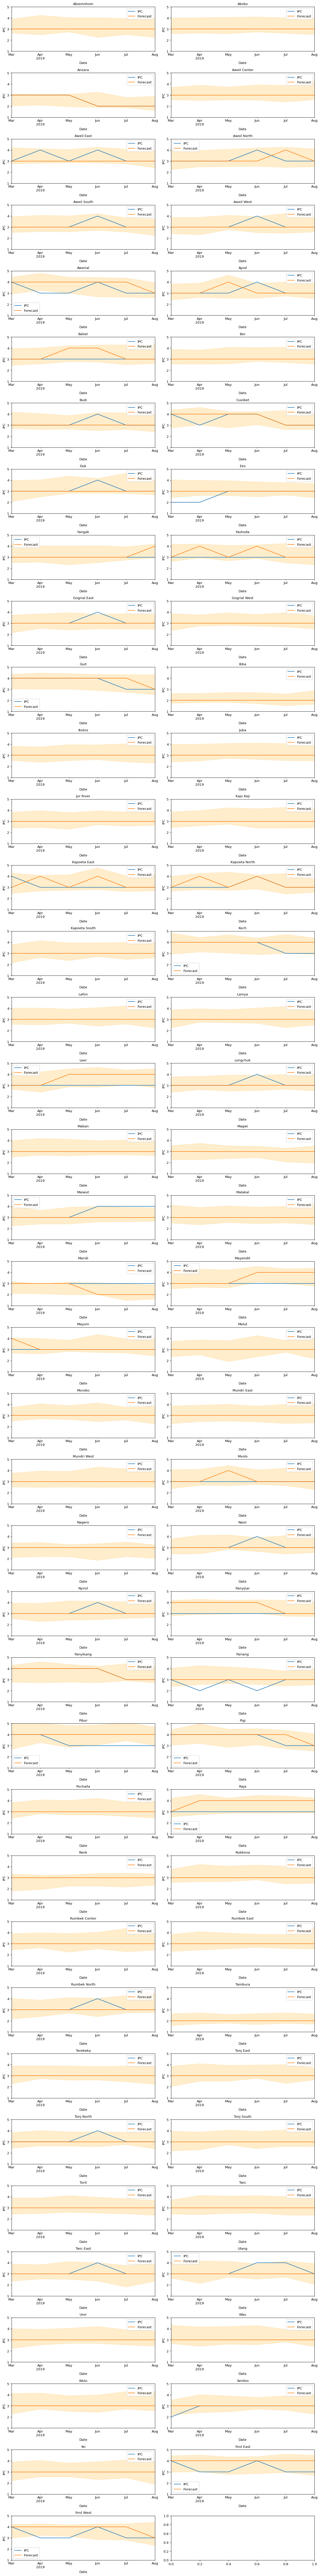

In [23]:
fig, ax = plt.subplots(39,2, figsize=(1280/96, 1280/12), dpi=96)
ax = ax.flatten()

for ax_, district in enumerate(all_preds['district'].unique()):
    
    p_ = all_preds.loc[all_preds['district'] == district]
    p_.plot(x='timestamp', y='ipc', ax=ax[ax_], label='IPC')
    p_.plot(x='timestamp', y='pred', ax=ax[ax_], label='Forecast')
    
    ax[ax_].fill_between(p_['timestamp'].values, p_['p10'], p_['p90'], alpha=0.2, color='orange')
    ax[ax_].set_title(district, fontsize=10)
    ax[ax_].legend(fontsize=10)
    ax[ax_].set_xlabel('Date', fontsize=10)
    ax[ax_].set_ylabel('IPC', fontsize=10)
    ax[ax_].tick_params(axis='both', which='major', labelsize=10)
    ax[ax_].tick_params(axis='both', which='minor', labelsize=10)
    ax[ax_].set_ylim(1,5)
    
fig.tight_layout()

## classification of months where ipc went up

In [24]:
all_preds['prev_ipc'] = all_preds['ipc'].shift(1)

In [25]:
ipc_increase_preds = all_preds[all_preds['ipc'] > all_preds['prev_ipc']]

# ipc_increase_preds[['prev_ipc', 'ipc','pred']]

In [48]:
classification_evaluation(ipc_increase_preds.ipc, ipc_increase_preds.pred)
print('relative frequency:', round(ipc_increase_preds.shape[0]/all_preds.shape[0], 2))

Accuracy: 0.538
Precision: 0.871
Recall: 0.538
f1-score: 0.578
Confusion matrix: 
 [[ 7  0]
 [18 14]]
relative frequency: 0.08


relative frequency: 0.08


## classification of months where ipc went down

In [27]:
all_preds['next_ipc'] = all_preds['ipc'].shift(-1)

In [28]:
ipc_decrease_preds = all_preds[all_preds['ipc'] > all_preds['next_ipc']]

# ipc_decrease_preds[['next_ipc', 'ipc','pred']]

In [47]:
classification_evaluation(ipc_decrease_preds.ipc, ipc_decrease_preds.pred)
print('relative frequency:', round(ipc_decrease_preds.shape[0]/all_preds.shape[0], 2))

Accuracy: 0.538
Precision: 0.871
Recall: 0.538
f1-score: 0.578
Confusion matrix: 
 [[ 7  0]
 [18 14]]
relative frequency: 0.08


relative frequency: 0.08


## classification of months where ipc stayed the same

In [30]:
# all_preds[['prev_ipc', 'ipc', 'next_ipc', 'pred']]

same_ipc = all_preds[all_preds.next_ipc == all_preds.ipc]
# same_ipc[['prev_ipc', 'ipc', 'next_ipc', 'pred']]

In [46]:
classification_evaluation(same_ipc.ipc, same_ipc.pred)
print('relative frequency:', round(same_ipc.shape[0]/all_preds.shape[0], 2))

Accuracy: 0.877
Precision: 0.949
Recall: 0.877
f1-score: 0.903
Confusion matrix: 
 [[ 12   1   0]
 [  3 310  40]
 [  0   3  14]]
relative frequency: 0.83


relative frequency: 0.83


# DeepAR w/o article topics

In [32]:
train2 = train[['district', 'ipc', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'timestamp']]

test2 = test[['district', 'ipc', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'timestamp']]

In [33]:
train_ds2 = PandasDataset.from_long_dataframe(train2, target='ipc', item_id='district', 
                                       timestamp='timestamp', freq='M')

In [34]:
estimator2 = DeepAREstimator(freq='M', prediction_length=6, num_layers=3, lr=0.002, context_length=12,
                            trainer_kwargs={'max_epochs':4})

predictor2 = estimator2.train(train_ds2, num_workers=4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Goshko\anaconda3\envs\dc3\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type        | Params | In sizes | Out sizes  
---------------------------------------------------------------
0 | model | DeepARModel | 36.4 K | ?        | [1, 100, 6]
---------------------------------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.146     Total estimated model params size (MB)


Epoch 0: : 50it [00:02, 18.55it/s, v_num=27, train_loss=1.150]

Epoch 0, global step 50: 'train_loss' reached 1.14718 (best 1.14718), saving model to 'C:\\Users\\Goshko\\Desktop\\DC3\\JBG060-DC3-23-24-Group24\\lightning_logs\\version_27\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: : 50it [00:02, 19.29it/s, v_num=27, train_loss=0.592]

Epoch 1, global step 100: 'train_loss' reached 0.59249 (best 0.59249), saving model to 'C:\\Users\\Goshko\\Desktop\\DC3\\JBG060-DC3-23-24-Group24\\lightning_logs\\version_27\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: : 50it [00:02, 18.99it/s, v_num=27, train_loss=0.526]

Epoch 2, global step 150: 'train_loss' reached 0.52636 (best 0.52636), saving model to 'C:\\Users\\Goshko\\Desktop\\DC3\\JBG060-DC3-23-24-Group24\\lightning_logs\\version_27\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: : 50it [00:02, 20.68it/s, v_num=27, train_loss=0.466]

Epoch 3, global step 200: 'train_loss' reached 0.46577 (best 0.46577), saving model to 'C:\\Users\\Goshko\\Desktop\\DC3\\JBG060-DC3-23-24-Group24\\lightning_logs\\version_27\\checkpoints\\epoch=3-step=200.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: : 50it [00:02, 20.39it/s, v_num=27, train_loss=0.466]


In [35]:
pred2 = list(predictor2.predict(train_ds2))
all_preds2 = list()

for district in pred2:
    
    district_name = district.item_id
    p = district.samples.mean(axis=0)
    # make 80% confidence interval
    p10 = np.percentile(district.samples, 10, axis=0)
    p90 = np.percentile(district.samples, 90, axis=0)
    dates = pd.date_range(start=district.start_date.to_timestamp(), periods=len(p), freq='M')
    dates2 = []
    
    for month in dates:
        day_num = month.strftime("%d")
        month_reset = month - timedelta(days=int(day_num) - 1)
        dates2.append(month_reset)
    
    district_pred = pd.DataFrame({'timestamp': dates2, 'district': district_name, 'pred': p, 'p10': p10, 'p90': p90})
    all_preds2 += [district_pred]

all_preds2 = pd.concat(all_preds2, ignore_index=True)

all_preds2 = all_preds2.merge(test2, on=['timestamp', 'district'], how='left')
all_preds2['pred'] = all_preds2['pred'].apply(round)

# all_preds2[['timestamp', 'district', 'ipc', 'pred', 'p10', 'p90']]

In [36]:
classification_evaluation(all_preds2['ipc'], all_preds2['pred'])

Accuracy: 0.866
Precision: 0.852
Recall: 0.866
f1-score: 0.846
Confusion matrix: 
 [[ 15   5   0]
 [ 12 375   6]
 [  0  39  10]]
